In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Analyzing Dataset**

In this data set, we try to estimate the level of knowledge of the student. To do this, we will apply exploratory data analysis, data visualization and classification techniques. However, our dataset is divided into two parts as training and testing. So we will combine them to complete the analysis at once.

In [2]:
info = pd.read_excel("/content/Data_User_Modeling_Dataset.xls", sheet_name = "Training_Data", usecols='I')
train = pd.read_excel("/content/Data_User_Modeling_Dataset.xls", sheet_name = "Training_Data", usecols='A:F')
test = pd.read_excel("/content/Data_User_Modeling_Dataset.xls", sheet_name = "Test_Data", usecols='A:F')

In [3]:
student_knowledge = pd.concat([train, test])

In [4]:
student_knowledge.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


In [5]:
student_knowledge.tail()

,STG,SCG,STR,LPR,PEG,UNS
140,0.90,0.78,0.62,0.32,0.89,High
141,0.85,0.82,0.66,0.83,0.83,High
142,0.56,0.60,0.77,0.13,0.32,Low
143,0.66,0.68,0.81,0.57,0.57,Middle
144,0.68,0.64,0.79,0.97,0.24,Middle


In [6]:
student_knowledge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 144
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STG     403 non-null    float64
 1   SCG     403 non-null    float64
 2   STR     403 non-null    float64
 3   LPR     403 non-null    float64
 4   PEG     403 non-null    float64
 5    UNS    403 non-null    object 
dtypes: float64(5), object(1)
memory usage: 22.0+ KB


As you can see there is a space at the beginning of the 'UNS' column. So let's fix the spacing issue and rename the column to Knowledge Level. Let's also examine the information column given in the excel file and discover the meanings of the columns.

In [7]:
info.head(6)

,Attribute Information:
0,STG (The degree of study time for goal object ...
1,SCG (The degree of repetition number of user f...
2,STR (The degree of study time of user for rela...
3,LPR (The exam performance of user for related ...
4,PEG (The exam performance of user for goal obj...
5,UNS (The knowledge level of user)


In [8]:
student_knowledge = student_knowledge.rename(columns={' UNS': 'Knowledge Level'})

In [9]:
student_knowledge.head()

,STG,SCG,STR,LPR,PEG,Knowledge Level
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


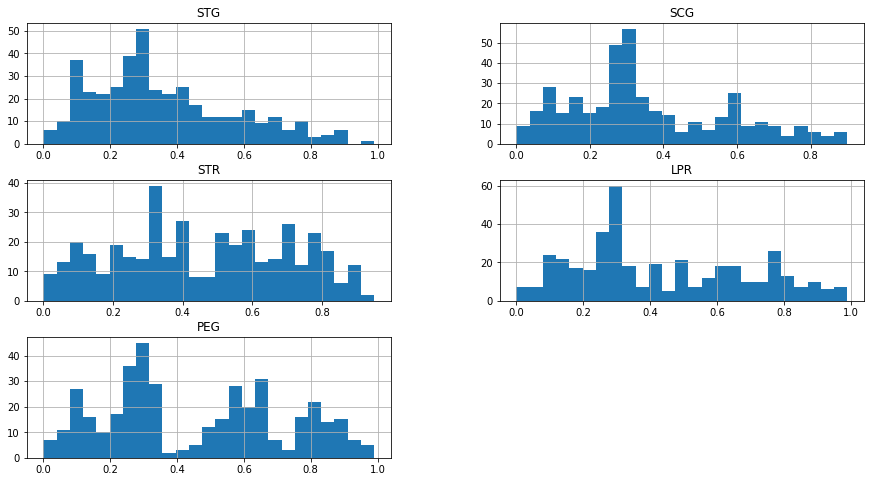

In [10]:
student_knowledge.hist(bins=25, figsize=(15, 8))
plt.show()

When we examine the histogram graph, we can see that some features are not normally distributed. For example, in the 'STG' column we can see that the tail of the graph falls on the right side of the histogram. Additionally, we see that the population density aggregates on the left side of the histogram. But in datasets where we have a small sample size, histogram plots might be deceptive. In this situations, we can use Quantile-Quantile method or in short Q-Q plots to determine whether our features distributed normally or not.

**Q-Q Plots**

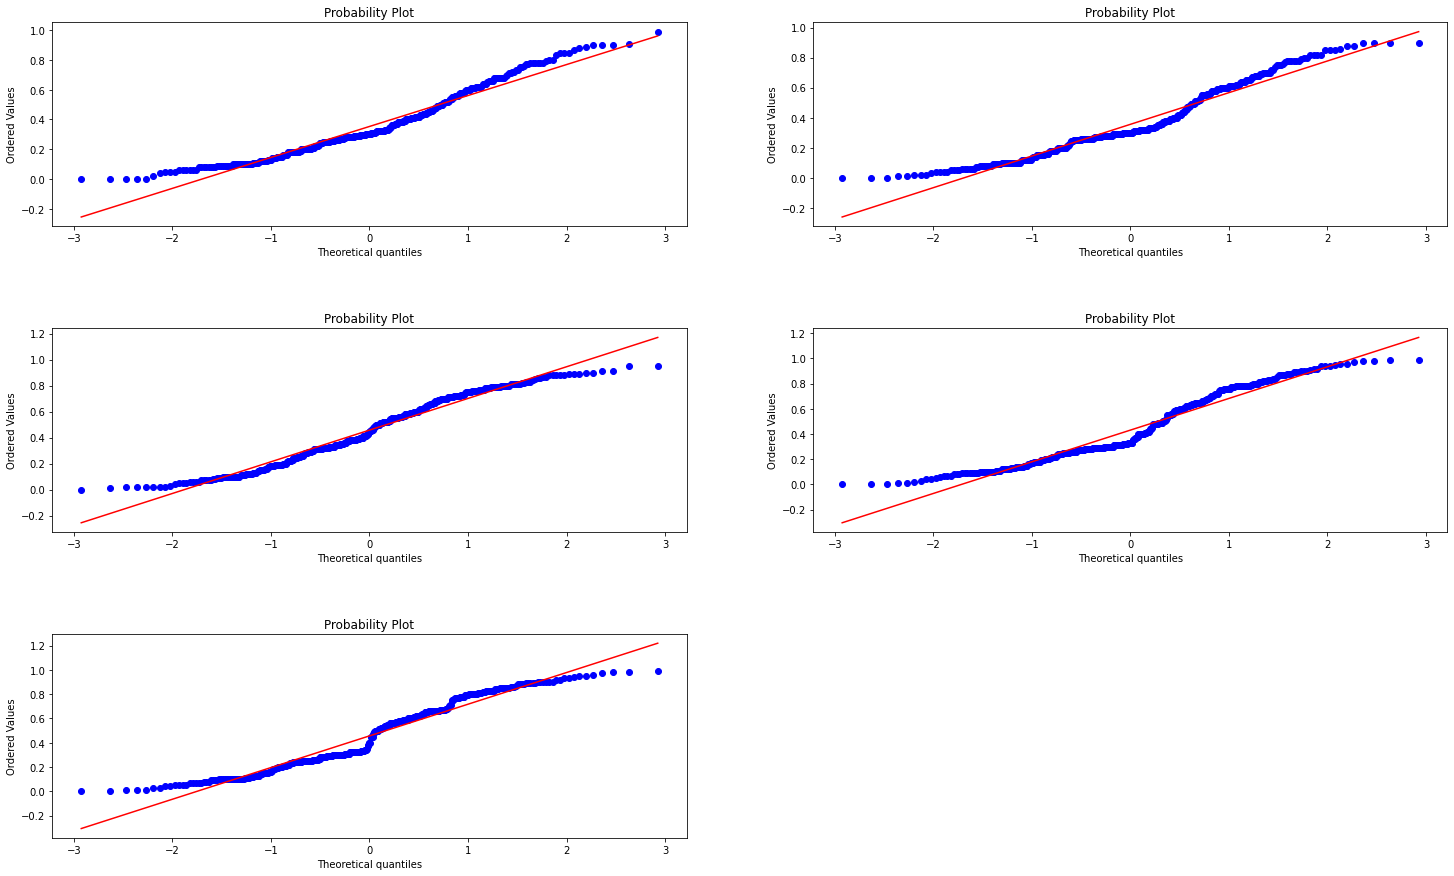

In [11]:
student_knowledge_copy = student_knowledge.copy()
student_knowledge_copy = student_knowledge_copy.drop('Knowledge Level', axis=1)

fig, axs = plt.subplots(3,2, figsize=(25, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
fig.delaxes(axs[2][1]) # Deletes empty plot at corresponding index

for ax, data in zip(axs.ravel(), student_knowledge_copy):
       stats.probplot(student_knowledge_copy[data], dist="norm", plot=ax)

plt.show()

When we examine the Q-Q graphs, we can clearly say that our features do not have a gaussian distribution (normal distribution). In particular, we can see that the tails have formed in the upper and lower parts on both sides. This shows us that our features peak very much in the middle.

**Analzing null values**

In [12]:
student_knowledge.isnull().sum()

STG                0
SCG                0
STR                0
LPR                0
PEG                0
Knowledge Level    0
dtype: int64

**Handling Categorical values**

Before analyzing outliers first deal with categorical values. In our dataset we have 1 categorical value which is 'UNS' category. We will replace categorical values by numerical values..

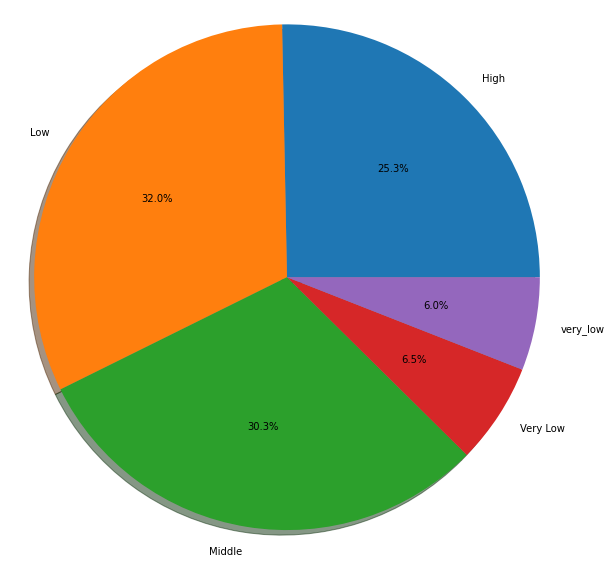

In [13]:
labels =  student_knowledge['Knowledge Level'].astype('category').cat.categories.tolist()
counts =  student_knowledge['Knowledge Level'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

As you can see, there are two identical attributes named differently, these are 'very_low' and 'Very Low'. So when converting categorical values, we can give the same value for both attributes.

In [14]:
replace_map = {'Knowledge Level': {'very_low':0, 'Very Low':0,'Low':1, 'Middle':2, 'High':3} }
student_knowledge.replace(replace_map, inplace=True)
student_knowledge.head()

,STG,SCG,STR,LPR,PEG,Knowledge Level
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,3
2,0.06,0.06,0.05,0.25,0.33,1
3,0.10,0.10,0.15,0.65,0.30,2
4,0.08,0.08,0.08,0.98,0.24,1


**Correlation between features and label**

Measuring correlation is a very important technique in the fields of data science and artifical intelligence. Before train our model we have to decide which feature we will use. In complex datasets we might have hundreds of columns which may not be usefull where performing model training. Correlation helps us to understand relations between features.  If correlation between feature and label is low, we might consider to not include in training data to improve models accuracy.

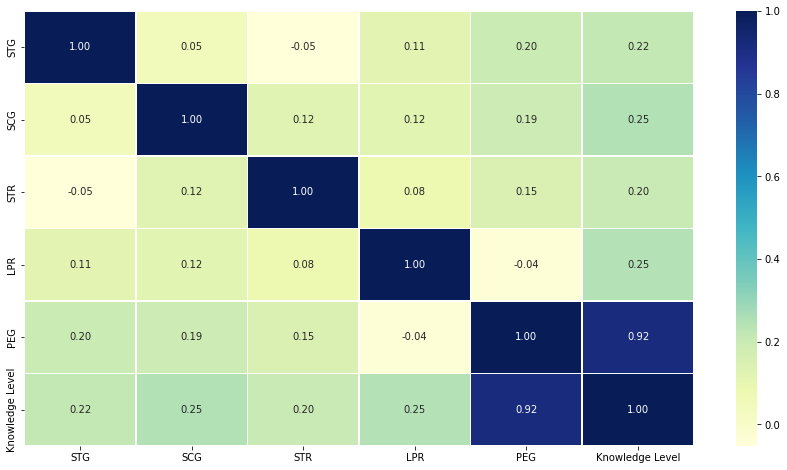

In [15]:
import seaborn as sns
from matplotlib import rcParams # For changing figure size

corr = student_knowledge.corr()
rcParams['figure.figsize'] = 15,8 # set figure size here
sns.heatmap(corr, linewidths=.5, cmap = 'YlGnBu', annot = True, fmt='.2f')

**Detecting Outliers** 

For detecting outliers we can use IQR (interquartile range) method and visualization we can use boxplots.

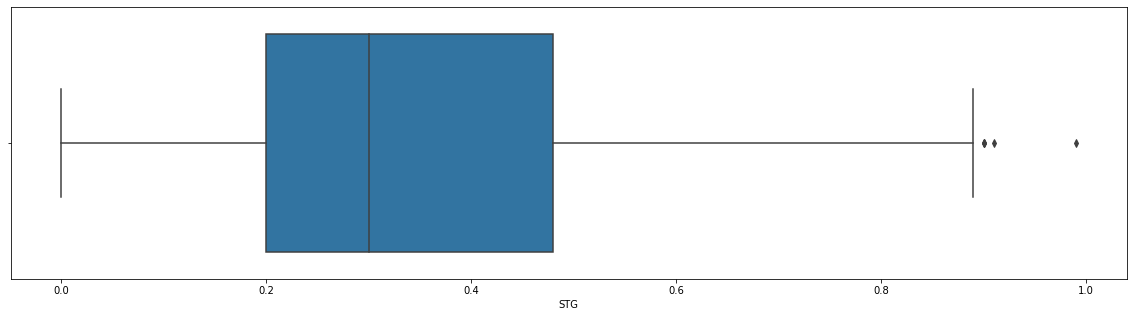

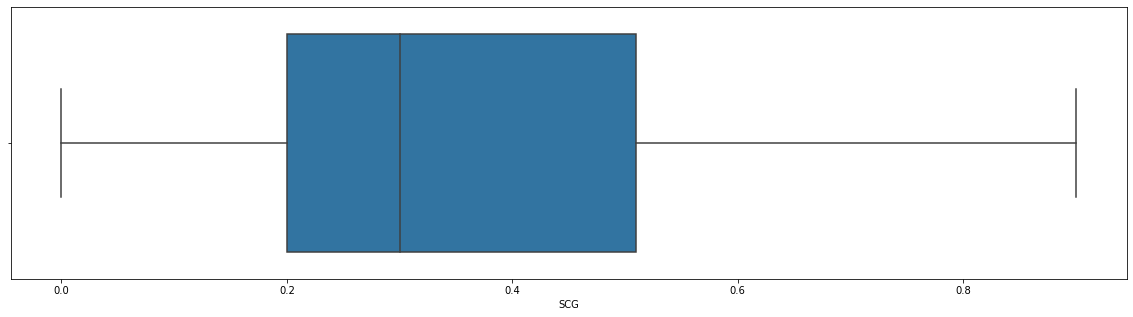

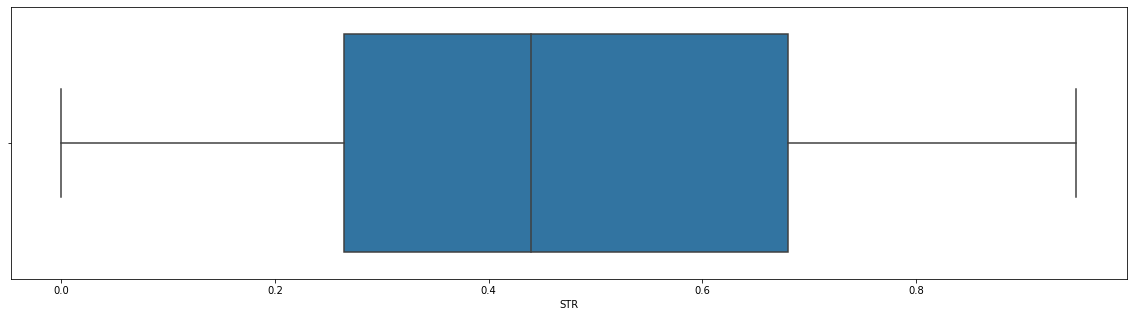

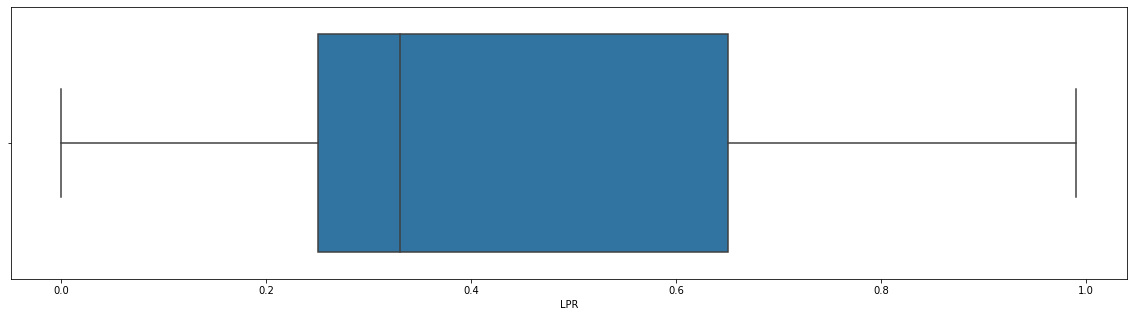

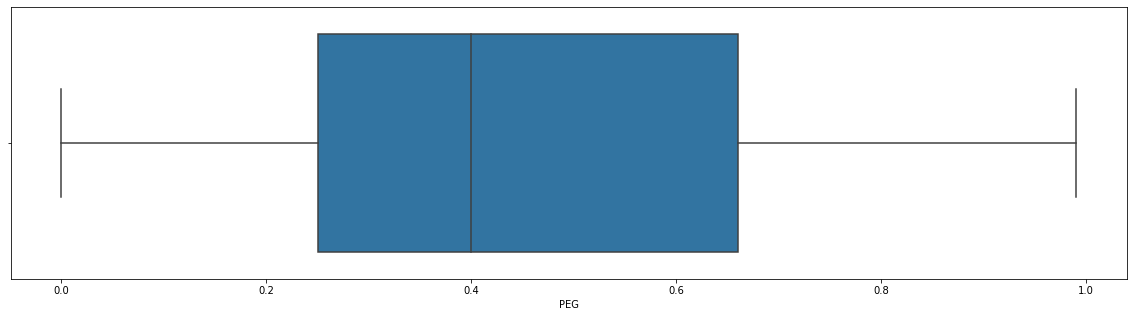

In [16]:
student_knowledge_copy = student_knowledge.copy()
student_knowledge_copy = student_knowledge_copy.drop('Knowledge Level', axis=1)
for data in student_knowledge_copy:
    plt.figure(figsize=(20, 5))
    sns.boxplot(student_knowledge_copy[data])

As we can see from boxplots we have some outliers in the 'STG' column. We will find outliers with using IQR method. After that we will replace them with median of the column.

In [17]:
def detect_outliers_iqr(dataset):
    outliers = []
    dataset = sorted(dataset)
    q1,q3 = np.percentile(dataset, [25,75])
    iqr = q3 - q1
    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    
    for elem in dataset:
        if elem < lower_fence or elem > upper_fence:
            outliers.append(elem)
    return outliers

In [18]:
sample_outliers = []
# We got 1, (len) because we don't want to look for outliers in categorical values.
for i in range(0, len(student_knowledge.count())-1):
    sample_outliers.append(detect_outliers_iqr(student_knowledge.iloc[:,i]))

In [19]:
def replace_outliers(data, sample_index):
    median = np.median(data)
    index = 0
    if len(sample_outliers[sample_index]) == 0: # returns if sample has no outlier
        return
    for (i, v) in data.iteritems():
        if sample_outliers[sample_index][index] == v:
            data[i] = median #replacing outlier with median value
            if index < len(sample_outliers[sample_index]) - 1:
                index +=1

In [20]:
student_knowledge_trimmed = student_knowledge.copy() # We copy our dataframe and replace outliers on this new dataframe.
for i in range(0, len(sample_outliers)-1):
    replace_outliers(student_knowledge_trimmed.iloc[:,i], i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
student_knowledge_trimmed.head()

,STG,SCG,STR,LPR,PEG,Knowledge Level
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,3
2,0.06,0.06,0.05,0.25,0.33,1
3,0.10,0.10,0.15,0.65,0.30,2
4,0.08,0.08,0.08,0.98,0.24,1


In [22]:
from sklearn.utils import shuffle
student_knowledge_final = shuffle(student_knowledge_trimmed)

In [23]:
#Split dataset into features and label
X = student_knowledge_final.drop('Knowledge Level', axis=1)
y = student_knowledge_final['Knowledge Level']

In [24]:
# Splitted dataset into 70% train 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

**Model Training with Machine learning techniques**

In this dataset we try to predict students knowledge level, which is a classification problem. In order to predict students knowledge we will apply several machine learning algorithm on this dataset. 

In [25]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xg

In [26]:
print("Number of train samples : ", X_train.shape[0])
print("Number of test samples :", X_test.shape[0])

Number of train samples :  282
Number of test samples : 121


**Supervised Machine Learning Tecniques**

**1. Logistic Regression**

In [27]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

print('Training score: ', logistic.score(X_train, y_train))
print('Testing score:  ', logistic.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

k = 9
kf = KFold(n_splits=k, random_state=None)
result = cross_val_score(logistic , X_train, y_train, cv = kf)
print("Avg accuracy: {}".format(result.mean()))

Training score:  0.8581560283687943
Testing score:   0.8347107438016529
Root Mean Squared Error: 0.4065578140908709
Avg accuracy: 0.7913306451612904


**2. K Nearest Neighbour Classifier (KNN)**



In [28]:
neigh = KNeighborsClassifier(n_neighbors= 11)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print('Training score: ', neigh.score(X_train, y_train))
print('Testing score:  ', neigh.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

k = 13
kf = KFold(n_splits=k, random_state=None)
result = cross_val_score(neigh , X_train, y_train, cv = kf)
print("Avg accuracy: {}".format(result.mean()))

Training score:  0.9184397163120568
Testing score:   0.9090909090909091
Root Mean Squared Error: 0.30151134457776363
Avg accuracy: 0.8583083583083583


**3. Desicion Trees Classifier**



In [29]:
desicion = DecisionTreeClassifier(random_state=0, max_depth=3, max_features = 0.5)
desicion.fit(X_train, y_train)
y_pred = desicion.predict(X_test)

print('Training score: ', desicion.score(X_train, y_train))
print('Testing score:  ', desicion.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

k = 13
kf = KFold(n_splits=k, random_state=None)
result = cross_val_score(desicion , X_train, y_train, cv = kf)
print("Avg accuracy: {}".format(result.mean()))

Training score:  0.8936170212765957
Testing score:   0.859504132231405
Root Mean Squared Error: 0.37482778414706003
Avg accuracy: 0.8618048618048619


**4. Random Forest Classifier** 

In [30]:
rf_clf = RandomForestClassifier(n_estimators=200, max_features = 0.7, max_depth=5)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print('Training score: ', rf_clf.score(X_train, y_train))
print('Testing score:  ', rf_clf.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

k = 7
kf = KFold(n_splits=k, random_state=None)
result = cross_val_score(rf_clf , X_train, y_train, cv = kf)
print("Avg accuracy: {}".format(result.mean()))

Training score:  0.975177304964539
Testing score:   0.9173553719008265
Root Mean Squared Error: 0.28747978728803447
Avg accuracy: 0.9255226480836235


**5. Ada Boost Classifier**

In [31]:
ada_clf= AdaBoostClassifier(random_state=0, n_estimators=250, learning_rate = 0.7)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

print('Training score: ', ada_clf.score(X_train, y_train))
print('Testing score:  ', ada_clf.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

k = 7
kf = KFold(n_splits=k, random_state=None)
result = cross_val_score(ada_clf , X_train, y_train, cv = kf)
print("Avg accuracy: {}".format(result.mean()))

Training score:  0.7021276595744681
Testing score:   0.7107438016528925
Root Mean Squared Error: 0.5378254348272378
Avg accuracy: 0.6807491289198605


**6. XGBoost Classifier**

In [36]:
xgb_clf = xg.XGBClassifier(n_estimators=200, booster='gbtree',  learning_rate=0.01)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print('Training score: ', xgb_clf.score(X_train, y_train))
print('Testing score:  ', xgb_clf.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

k = 9
kf = KFold(n_splits=k, random_state=None)
result = cross_val_score(xgb_clf , X_train, y_train, cv = kf)
print("Avg accuracy: {}".format(result.mean()))

Training score:  0.9680851063829787
Testing score:   0.9256198347107438
Root Mean Squared Error: 0.2727272727272727
Avg accuracy: 0.9255152329749105


When we analyze the results, XGBoost Classifier and Random Forest Classifier give the best cross validation scores. Desicion Tree and KNN Classifers give satisfactory results close to each other. The worst performing algorithm is AdaBoost Classifier.